# 0. Załadowanie i wstępna eksploracja danych

In [1]:
import pandas as pd

# Wczytywanie danych eCommerce cosmetics
file_paths = [
    './data/cosmetics/2019-Oct.csv',
    './data/cosmetics/2019-Nov.csv',
    './data/cosmetics/2019-Dec.csv',
    './data/cosmetics/2020-Jan.csv',
    './data/cosmetics/2020-Feb.csv'
]

# Łączenie wielu plików w jeden DataFrame
dataframes = []
for path in file_paths:
    try:
        df = pd.read_csv(path)
        dataframes.append(df)
        print(f"{path} wczytano poprawnie, rozmiar: {len(df)} wierszy.")
    except Exception as e:
        print(f"Nie udało się wczytać {path}: {e}")

analiza_rfm = pd.concat(dataframes, ignore_index=True)
print(f"Łączny rozmiar danych: {len(analiza_rfm)} wierszy, {analiza_rfm.shape[1]} kolumn.")


./data/cosmetics/2019-Oct.csv wczytano poprawnie, rozmiar: 4102283 wierszy.
./data/cosmetics/2019-Nov.csv wczytano poprawnie, rozmiar: 4635837 wierszy.
./data/cosmetics/2019-Dec.csv wczytano poprawnie, rozmiar: 3533286 wierszy.
./data/cosmetics/2020-Jan.csv wczytano poprawnie, rozmiar: 4264752 wierszy.
./data/cosmetics/2020-Feb.csv wczytano poprawnie, rozmiar: 4156682 wierszy.
Łączny rozmiar danych: 20692840 wierszy, 9 kolumn.


In [3]:
# Wstępna eksploracja
analiza_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20692840 entries, 0 to 20692839
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 1.4+ GB


In [4]:
analiza_rfm.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9


# 1. Filtrowanie danych dla zakupów

In [5]:
# Filtrowanie eventów, gdzie event_type to 'purchase'
purchase_data = analiza_rfm[analiza_rfm['event_type'] == 'purchase']

In [6]:
purchase_data.shape

(1287007, 9)

# 2. Przekształcenie daty i wyliczenie wartości recency, frequency, monetary

In [7]:
# Konwersja kolumny event_time na typ daty
purchase_data['event_time'] = pd.to_datetime(purchase_data['event_time'])

# Agregowanie danych na poziomie user_id
rfm = purchase_data.groupby('user_id').agg({
    'event_time': lambda x: (purchase_data['event_time'].max() - x.max()).days,  # Recency
    'user_session': 'count',  # Frequency (liczba transakcji)
    'price': 'sum'  # Monetary (całkowity wydany budżet)
}).reset_index()

# Zmiana nazw kolumn
rfm.columns = ['user_id', 'Recency', 'Frequency', 'Monetary']


C:\Users\nazwa\AppData\Local\Temp\ipykernel_23508\2622782569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_data['event_time'] = pd.to_datetime(purchase_data['event_time'])


In [8]:
rfm.head()

,user_id,Recency,Frequency,Monetary
0,9794320,96,4,12.68
1,10079204,115,2,25.81
2,10280338,10,86,177.83
3,12055855,71,4,16.54
4,12936739,43,2,29.89


In [10]:
rfm.shape

(110518, 4)

# 3. Tworzenie kwartyli dla RFM

In [11]:
# Tworzenie kwartyli dla każdej miary RFM
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

rfm['R'] = pd.qcut(rfm['Recency'], q=4, labels=r_labels)
rfm['F'] = pd.qcut(rfm['Frequency'], q=4, labels=f_labels)
rfm['M'] = pd.qcut(rfm['Monetary'], q=4, labels=m_labels)

# Tworzenie segmentu RFM
rfm['RFM_Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1).astype(int)


In [12]:
rfm.head()

,user_id,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
0,9794320,96,4,12.68,2,2,1,221,5
1,10079204,115,2,25.81,1,1,2,112,4
2,10280338,10,86,177.83,4,4,4,444,12
3,12055855,71,4,16.54,2,2,2,222,6
4,12936739,43,2,29.89,3,1,2,312,6


# 4. Analiza wyników

In [13]:
## Największe segmenty RFM
print(rfm['RFM_Segment'].value_counts().head(10))

RFM_Segment
444    7406
111    5067
344    4980
211    4628
311    4349
411    4214
244    3906
233    3001
333    2954
133    2905
Name: count, dtype: int64


In [15]:
# Analiza średnich wartości dla każdego poziomu RFM_Score
rfm_analysis = rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'user_id': 'count'  # Liczba użytkowników w każdej grupie
}).rename(columns={'user_id': 'Customer_Count'}).round(1)

In [16]:

rfm_analysis


,Recency,Frequency,Monetary,Customer_Count
RFM_Score,,,,
3,128.3,2.0,10.7,5067
4,108.7,2.6,14.3,9426
5,89.0,3.3,18.8,13162
6,70.2,4.1,24.2,16459
7,71.0,6.0,34.6,14828
8,67.8,8.7,45.5,13607
9,64.9,14.4,70.1,12683
10,52.4,19.7,91.9,10125
11,35.0,27.8,129.0,7755


# 5. Grupowanie w segmenty biznesowe

In [17]:
# Przykład funkcji segmentacji

def rfm_level(row):
    if row['RFM_Score'] >= 10:
        return 'Top'
    elif row['RFM_Score'] >= 6:
        return 'Middle'
    else:
        return 'Low'

rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)

# Analiza segmentów
rfm_segment_analysis = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'user_id': 'count'  # Liczba użytkowników
}).rename(columns={'user_id': 'Customer_Count'}).round(1)

print(rfm_segment_analysis)


           Recency  Frequency  Monetary  Customer_Count
RFM_Level                                              
Low          102.9        2.8      15.8           27655
Middle        68.7        7.9      42.0           57577
Top           35.8       29.7     138.1           25286


# 6. Wizualizacja wyników

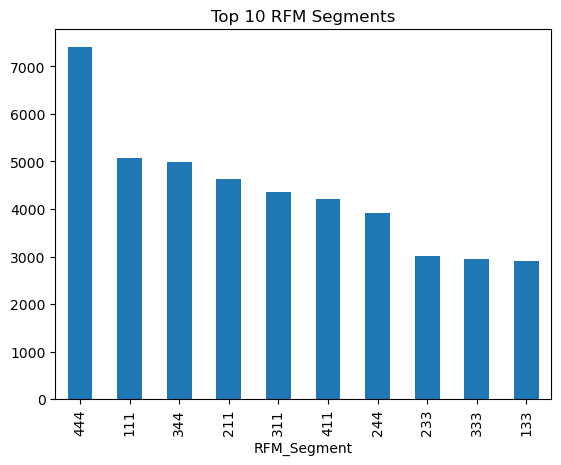

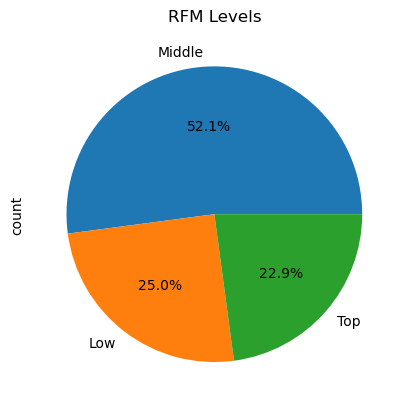

In [18]:
# Wykresy dla segmentów RFM
import matplotlib.pyplot as plt

# Rozkład segmentów
rfm['RFM_Segment'].value_counts().head(10).plot(kind='bar', title='Top 10 RFM Segments')
plt.show()

# Rozkład poziomów RFM
rfm['RFM_Level'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='RFM Levels')
plt.show()


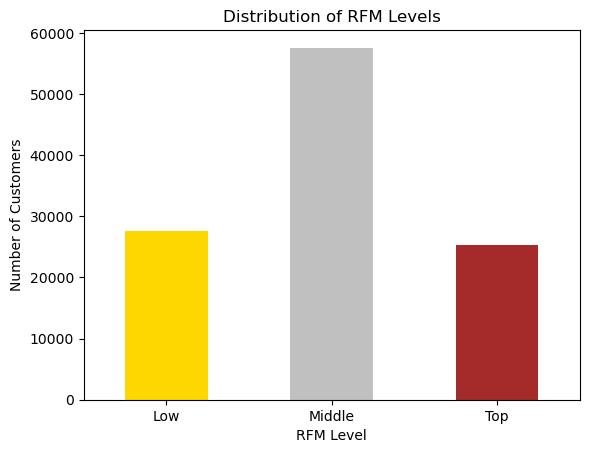

In [19]:
# Alternatywa dla wykresu kołowego

rfm['RFM_Level'].value_counts().sort_index().plot(
    kind='bar',
    color=['gold', 'silver', 'brown'],
    title='Distribution of RFM Levels'
)
plt.ylabel('Number of Customers')
plt.xlabel('RFM Level')
plt.xticks(rotation=0)
plt.show()


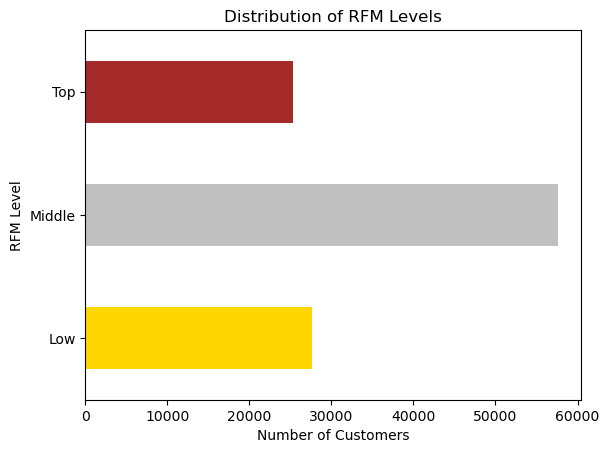

In [21]:
rfm['RFM_Level'].value_counts().sort_index().plot(
    kind='barh',
    color=['gold', 'silver', 'brown'],
    title='Distribution of RFM Levels'
)
plt.xlabel('Number of Customers')
plt.ylabel('RFM Level')
plt.show()


C:\Users\nazwa\AppData\Local\Temp\ipykernel_23508\3781518596.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='RFM_Level', y='Monetary', data=rfm, palette='Set2')


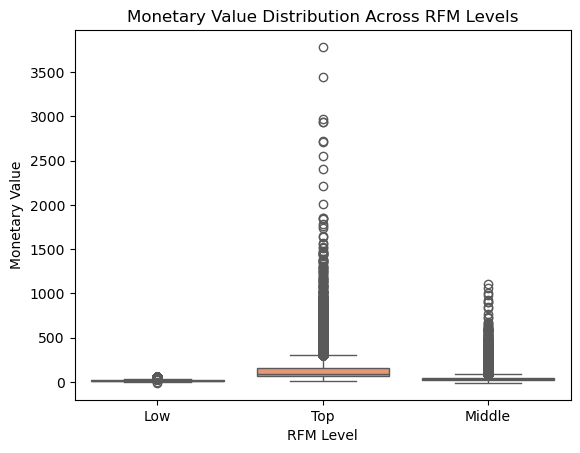

In [22]:
import seaborn as sns

sns.boxplot(x='RFM_Level', y='Monetary', data=rfm, palette='Set2')
plt.title('Monetary Value Distribution Across RFM Levels')
plt.ylabel('Monetary Value')
plt.xlabel('RFM Level')
plt.show()


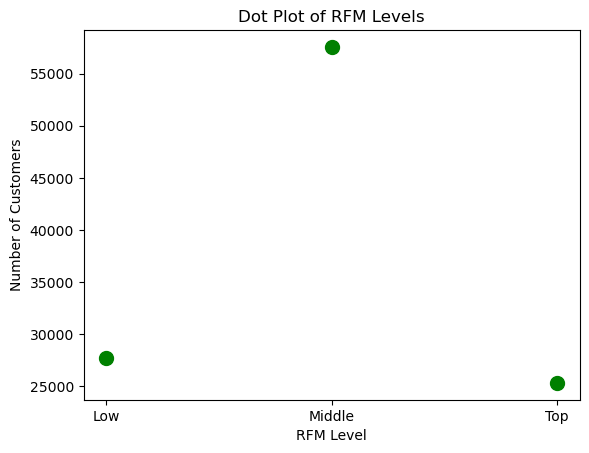

In [23]:
rfm_segment_sizes = rfm['RFM_Level'].value_counts().sort_index()
plt.scatter(rfm_segment_sizes.index, rfm_segment_sizes.values, color='green', s=100)
plt.title('Dot Plot of RFM Levels')
plt.ylabel('Number of Customers')
plt.xlabel('RFM Level')
plt.show()


# 7. Głębsza analiza RFM

In [29]:
rfm_analysis

,Recency,Frequency,Monetary,Customer_Count
RFM_Score,,,,
3,128.3,2.0,10.7,5067
4,108.7,2.6,14.3,9426
5,89.0,3.3,18.8,13162
6,70.2,4.1,24.2,16459
7,71.0,6.0,34.6,14828
8,67.8,8.7,45.5,13607
9,64.9,14.4,70.1,12683
10,52.4,19.7,91.9,10125
11,35.0,27.8,129.0,7755


In [30]:
rfm_segment_analysis

,Recency,Frequency,Monetary,Customer_Count
RFM_Level,,,,
Low,102.9,2.8,15.8,27655
Middle,68.7,7.9,42.0,57577
Top,35.8,29.7,138.1,25286


In [31]:
rfm

,user_id,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
0,9794320,96,4,12.68,2,2,1,221,5,Low
1,10079204,115,2,25.81,1,1,2,112,4,Low
2,10280338,10,86,177.83,4,4,4,444,12,Top
3,12055855,71,4,16.54,2,2,2,222,6,Middle
4,12936739,43,2,29.89,3,1,2,312,6,Middle
...,...,...,...,...,...,...,...,...,...,...
110513,622065819,0,4,20.48,4,2,2,422,8,Middle
110514,622066161,0,4,12.95,4,2,1,421,7,Middle
110515,622067983,0,10,66.48,4,3,4,434,11,Top
110516,622069477,0,1,0.95,4,1,1,411,6,Middle


- Sumaryczne przychody generowane przez każdy segment.

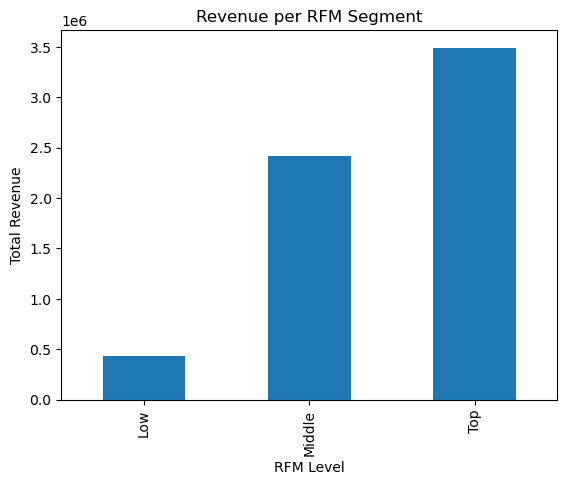

In [33]:
revenue_per_segment = rfm.groupby('RFM_Level')['Monetary'].sum()
revenue_per_segment.plot(kind='bar', title='Revenue per RFM Segment')
plt.ylabel('Total Revenue')
plt.xlabel('RFM Level')
plt.show()


- jak segmenty zmieniają się w czasie (np. tygodniowo lub dziennie). Pozwala to zobaczyć, czy np. liczba klientów w segmencie Top rośnie, czy maleje